In [2]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import yfinance as yf  # Import yfinance library for fetching historical ticker data
import math
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model
from arch.univariate import HARX
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings
warnings.simplefilter('ignore')


Text(0, 0.5, 'Averaged RV')

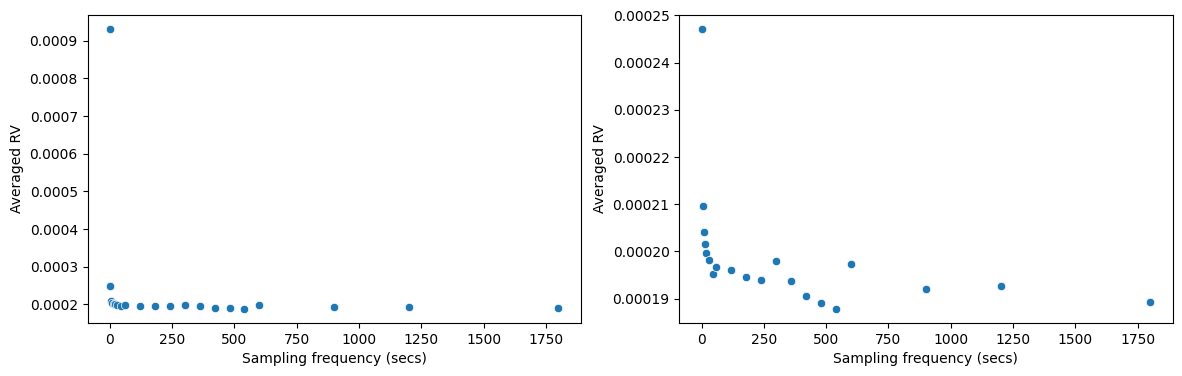

In [3]:

# =============================================================================
# Volatility Signature Plot
# =============================================================================
RVdf = pd.read_csv('Datasets\AAPL_RV.csv')  
RVdf.set_index('Date',inplace=True)

# Compute Average RVs across different days
RVav = RVdf.mean()
# Convert index to integers (sec)
RVav.index
time = [0] + [pd.Timedelta(x).total_seconds() for x in RVav.index[1:]]

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
sns.scatterplot(x=time,y=RVav,ax=axes[0])
axes[0].set_xlabel('Sampling frequency (secs)')
axes[0].set_ylabel('Averaged RV')
sns.scatterplot(x=time[1:],y=RVav[1:],ax=axes[1])
axes[1].set_xlabel('Sampling frequency (secs)')
axes[1].set_ylabel('Averaged RV')


In [4]:
RVav.index[1:]

Index(['1s', '5s', '10s', '15s', '20s', '30s', '45s', '1min', '2min', '3min',
       '4min', '5min', '6min', '7min', '8min', '9min', '10min', '15min',
       '20min', '30min'],
      dtype='object')

In [6]:
RVdf

,tick,1s,5s,10s,15s,20s,30s,45s,1min,2min,...,4min,5min,6min,7min,8min,9min,10min,15min,20min,30min
Date,,,,,,,,,,,,,,,,,,,,,
20150102,0.000636,0.000320,0.000266,0.000285,0.000264,0.000252,0.000281,0.000263,0.000276,0.000302,...,0.000337,0.000422,0.000279,0.000401,0.000419,0.000396,0.000311,0.000452,0.000300,0.000423
20150105,0.000629,0.000309,0.000269,0.000265,0.000277,0.000270,0.000280,0.000253,0.000278,0.000271,...,0.000298,0.000323,0.000169,0.000183,0.000202,0.000161,0.000183,0.000170,0.000142,0.000177
20150106,0.000800,0.000453,0.000404,0.000399,0.000384,0.000390,0.000384,0.000336,0.000377,0.000389,...,0.000412,0.000474,0.000438,0.000518,0.000541,0.000426,0.000512,0.000608,0.000512,0.000735
20150107,0.000439,0.000298,0.000272,0.000241,0.000241,0.000228,0.000219,0.000213,0.000212,0.000216,...,0.000145,0.000157,0.000112,0.000143,0.000130,0.000112,0.000099,0.000107,0.000092,0.000135
20150108,0.000466,0.000193,0.000147,0.000136,0.000134,0.000127,0.000127,0.000126,0.000137,0.000139,...,0.000138,0.000129,0.000150,0.000164,0.000173,0.000143,0.000117,0.000161,0.000142,0.000155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,0.000440,0.000111,0.000101,0.000100,0.000103,0.000099,0.000091,0.000100,0.000087,0.000081,...,0.000090,0.000085,0.000078,0.000059,0.000094,0.000071,0.000083,0.000099,0.000083,0.000052
20211228,0.000620,0.000186,0.000158,0.000154,0.000155,0.000161,0.000152,0.000142,0.000141,0.000153,...,0.000149,0.000147,0.000182,0.000129,0.000139,0.000188,0.000180,0.000153,0.000200,0.000078
20211229,0.000427,0.000142,0.000122,0.000118,0.000112,0.000121,0.000099,0.000103,0.000093,0.000091,...,0.000098,0.000104,0.000124,0.000140,0.000109,0.000126,0.000131,0.000107,0.000162,0.000101


In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
#from arch import arch_model
from arch.univariate import HARX
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)


In [3]:
df=pd.read_csv('Datasets\AAPL_20200102.csv.gz', compression='gzip')
df.head()

# =============================================================================
# Data cleaning
# =============================================================================
# Remove entries with zero or negative bid, ask, transanction price or size



<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\prvij\AppData\Local\Temp\ipykernel_9484\491745702.py:1: SyntaxWarning: invalid escape sequence '\A'
  df=pd.read_csv('Datasets\AAPL_20200102.csv.gz', compression='gzip')


,DATE,TIME_M,SYM_ROOT,EX,SIZE,PRICE,NBO,NBB,NBOqty,NBBqty,midpoint,BuySellLR,BuySellEMO,BuySellCLNV
0,02JAN2020,34200.134554,AAPL,K,250.0,296.24,296.29,296.24,100.0,200.0,296.265,-1.0,-1.0,-1.0
1,02JAN2020,34200.134577,AAPL,K,50.0,296.24,296.29,296.21,100.0,100.0,296.250,-1.0,NaN,NaN
2,02JAN2020,34200.134742,AAPL,K,108.0,296.21,296.29,296.21,100.0,100.0,296.250,-1.0,-1.0,-1.0
3,02JAN2020,34200.157564,AAPL,P,1.0,296.28,296.29,296.10,200.0,100.0,296.195,1.0,1.0,1.0
4,02JAN2020,34200.157564,AAPL,P,1.0,296.28,296.29,296.10,200.0,100.0,296.195,1.0,1.0,1.0


In [5]:
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | \
    (df['PRICE'] <= 0) | (df['SIZE'] <= 0)

In [6]:
df_out

0         False
1         False
2         False
3         False
4         False
          ...  
273629    False
273630    False
273631    False
273632    False
273633    False
Length: 273634, dtype: bool

In [7]:
df = df[~df_out].reset_index(drop=True)

In [8]:
len(df)

273634

In [9]:
df['Stamp'] = pd.to_datetime(df['DATE']) + df['TIME_M'].apply(lambda x: pd.Timedelta(x,unit='sec'))
df.set_index('Stamp', drop=True, inplace = True)


In [10]:
df

,DATE,TIME_M,SYM_ROOT,EX,SIZE,PRICE,NBO,NBB,NBOqty,NBBqty,midpoint,BuySellLR,BuySellEMO,BuySellCLNV
Stamp,,,,,,,,,,,,,,
2020-01-02 09:30:00.134553762,02JAN2020,34200.134554,AAPL,K,250.0,296.2400,296.29,296.24,100.0,200.0,296.265,-1.0,-1.0,-1.0
2020-01-02 09:30:00.134577180,02JAN2020,34200.134577,AAPL,K,50.0,296.2400,296.29,296.21,100.0,100.0,296.250,-1.0,NaN,NaN
2020-01-02 09:30:00.134742137,02JAN2020,34200.134742,AAPL,K,108.0,296.2100,296.29,296.21,100.0,100.0,296.250,-1.0,-1.0,-1.0
2020-01-02 09:30:00.157563825,02JAN2020,34200.157564,AAPL,P,1.0,296.2800,296.29,296.10,200.0,100.0,296.195,1.0,1.0,1.0
2020-01-02 09:30:00.157564014,02JAN2020,34200.157564,AAPL,P,1.0,296.2800,296.29,296.10,200.0,100.0,296.195,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:59.944672526,02JAN2020,57599.944673,AAPL,Q,4370.0,300.6000,300.60,300.58,6700.0,6800.0,300.590,1.0,1.0,1.0
2020-01-02 15:59:59.963696249,02JAN2020,57599.963696,AAPL,P,200.0,300.6000,300.60,300.58,2300.0,6900.0,300.590,1.0,1.0,1.0
2020-01-02 15:59:59.984673484,02JAN2020,57599.984673,AAPL,D,500.0,300.5900,300.60,300.58,2300.0,7100.0,300.590,-1.0,-1.0,-1.0


In [3]:
''
### Import merged data from TAQ for AAPL on 02/01/2020
df=pd.read_csv('AAPL_20200102.csv.gz', compression='gzip')
df.head()

# =============================================================================
# Data cleaning
# =============================================================================
# Remove entries with zero or negative bid, ask, transanction price or size
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | \
    (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# Remove entries with negative bid-ask spread
df['SPREAD'] = df['NBO'] - df['NBB']
df = df[~(df['SPREAD'] <= 0)].reset_index(drop=True)

# Check if there are duplicated entries
df['TIME_M'].duplicated(keep=False).sum()

# Remove entries for which the spread is more that 50 times the median spread on that day
medspread = df['SPREAD'].median()
df = df[~(df['SPREAD'] > 50*medspread)].reset_index(drop=True)

# Create a timestamp variable and set it as the index
df['Stamp'] = pd.to_datetime(df['DATE']) + df['TIME_M'].apply(lambda x: pd.Timedelta(x,unit='sec'))
df.set_index('Stamp', drop=True, inplace = True)

# =============================================================================
# Descriptive analysis
# =============================================================================
## Time series plot
df[['PRICE','NBO','NBB','midpoint']].plot(figsize=(6,4))

## Need to do filtering T4 also
## Delete entries with prices that are above the `ask' plus the bid–ask spread. 
## Similar for entries with prices below the `bid' minus the bid–ask spread
df_out = (df['PRICE'] > df['NBO'] + df['SPREAD']) | (df['PRICE'] < df['NBB'] - df['SPREAD'])
df = df[~df_out]
df[['PRICE','NBO','NBB','midpoint']].plot(figsize=(6,4))

## Bid-ask spread
df['SPREAD'].plot(figsize=(6,4),title='Bid-ask Spread')
df.groupby('BuySellLR')['SPREAD'].describe()

## Trading volumes
df['SIZE'].plot(figsize=(6,4),title='Trading Volume') # There is a big trade at early of the day

df['SIZE'].max() # 424836.0
tmp = df.loc[df['SIZE'] == df['SIZE'].max()]

df[df['SIZE'] != df['SIZE'].max()]['SIZE'].plot(figsize=(6,4),title='Trading Volume')

df.groupby('BuySellLR')['SIZE'].describe()
df[df['SIZE'] != df['SIZE'].max()].groupby('BuySellLR')['SIZE'].describe()

## Tick-by-tick returns
df['Return'] = np.log(df['PRICE']/df['PRICE'].shift(1))
df['Return'].plot(figsize=(6,4),title='Return')
df.groupby('BuySellLR')['Return'].describe()


'''
Computing Realized Volatility
'''

# =============================================================================
# Computing 5-min RV
# =============================================================================
### Method 1: Sampling log prices every 5 mins
lprice = np.log(df['PRICE'])

### First, need to sample log prices every 5 minutes
lprice_5m = lprice.resample(rule='5min',closed ='right',label ='right').apply('last')

### Compute log returns
ret_5m = lprice_5m.diff()
ret_5m.iloc[0] = lprice_5m.iloc[0] - lprice.iloc[0]

### 5-min RV
RV_5m = sum(ret_5m**2)


### Method 2: Sampling returns every 5 mins
returns = df['Return'].dropna()
returns_5m = returns.resample(rule='5min',closed ='right',label ='right').apply('sum')
RV_5mb = sum(returns_5m**2)

# =============================================================================
# Computing RV using different sampling frequencies
# =============================================================================
def RV(ret,freq='5min'):
    # ret: pandas series of intraday log returns with datetime index
    # freq: string - frequency to be used
    
    ret.dropna(inplace=True)
    ret_freq = ret.resample(rule=freq,closed ='right',label ='right').apply('sum')
    return sum(ret_freq**2)


freqs = ['1s', '5s', '10s', '15s', '30s',
         '1min', '2min', '5min', '10min', '15min', '20min', '30min']
RVs = {freq: RV(returns,freq) for freq in freqs}
RVs['tick'] = sum(returns**2)
# Reorder frequencies
RVs = {freq: RVs[freq] for freq in ['tick']+freqs} 
# Convert RVs to data frame
RVs = pd.Series(RVs)
# Scale/multiply RVs by 10000
RVs = RVs*10000
RVs

FileNotFoundError: [Errno 2] No such file or directory: 'AAPL_20200102.csv.gz'

In [2]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
#from arch import arch_model
from arch.univariate import HARX
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
